# Project B: Knowledge Distillation in MHIST Dataset

## Data Processing

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import matplotlib.pyplot as plt

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 32

import pandas as pd
import os
import glob
from google.colab import files
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn import preprocessing
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
project_path = '/content/gdrive/MyDrive/ECE1512/ProjectA'
annotations = pd.read_csv(project_path + '/mhist_dataset/annotations.csv')
annotations.set_index('Image Name', inplace=True)
annotations

,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition
Image Name,,,
MHIST_aaa.png,SSA,6,train
MHIST_aab.png,HP,0,train
MHIST_aac.png,SSA,5,train
MHIST_aae.png,HP,1,train
MHIST_aaf.png,SSA,5,train
...,...,...,...
MHIST_cpn.png,SSA,7,train
MHIST_cfc.png,SSA,7,test
MHIST_cgp.png,SSA,7,test


In [ ]:
images_path = '/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images'
images_name = os.listdir(images_path)

In [ ]:
mhist_train_label = []      #WITHOUT data augmentation
mhist_train_img = []
mhist_test_img = []
mhist_test_label = []


for img in images_name:

    if annotations.loc[img]['Partition'] == 'train':
        img_train_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_train_data = np.asarray(img_train_origin)
        mhist_train_img.append(img_train_data)
        img_train_label = annotations.loc[img]['Majority Vote Label']
        mhist_train_label.append(img_train_label)

    if annotations.loc[img]['Partition'] == 'test':
        img_test_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_test_data = np.asarray(img_test_origin)
        mhist_test_img.append(img_test_data)        
        img_label = annotations.loc[img]['Majority Vote Label']
        mhist_test_label.append(img_label)

In [ ]:
mhist_train_img = []    #WITH data augmentation
mhist_train_label = []
mhist_test_img = []
mhist_test_label = []
datagen = ImageDataGenerator(brightness_range=[0.2,1.0],
                          zoom_range=[0.5,1.0],
                          rotation_range=180)
for img in images_name:

    if annotations.loc[img]['Partition'] == 'train':
        img_train_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_train_data = np.asarray(img_train_origin)

        samples = expand_dims(img_train_data, 0)
        it = datagen.flow(samples, batch_size=32)
        batch = it.next()
        image = batch[0].astype('uint8')
        mhist_train_img.append(image)


        img_train_label = annotations.loc[img]['Majority Vote Label']
        mhist_train_label.append(img_train_label)
    if annotations.loc[img]['Partition'] == 'test':
        img_test_origin = Image.open('/content/gdrive/MyDrive/ECE1512/ProjectA/mhist_dataset/images/' + img)
        img_test_data = np.asarray(img_test_origin)



        samples = expand_dims(img_test_data, 0)
        it = datagen.flow(samples, batch_size=32)
        batch = it.next()
        image = batch[0].astype('uint8')
        mhist_test_img.append(image)



        img_label = annotations.loc[img]['Majority Vote Label']
        mhist_test_label.append(img_label)
print('Done')

Done


In [ ]:
mhist_train_img = np.array(mhist_train_img)
mhist_train_label = np.array(mhist_train_label)
mhist_test_img = np.array(mhist_test_img)
mhist_test_label = np.array(mhist_test_label)
mhist_train_img = mhist_train_img/255
mhist_test_img = mhist_test_img/255

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(mhist_train_label)
mhist_train_label_le = le.transform(mhist_train_label)
mhist_test_label_le = le.transform(mhist_test_label)

## Build Model

In [ ]:
from tensorflow.keras.models import Model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
# Build  teacher.
def teacher_initial():
  Res = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(224, 224, 3))
  #Res.trainable = False
  for layer in Res.layers[:185]:
    layer.trainable = False
  for layer in Res.layers[-5:]:
    layer.trainable = True

  average_tea = tf.keras.layers.GlobalAveragePooling2D()(Res.output)
  dense_tea = tf.keras.layers.Dense(2, activation = 'softmax')(average_tea)
  teacher_model = Model(inputs=Res.input, outputs=dense_tea)
  return teacher_model


In [ ]:
# Build student.
def student_initial():
  Mob = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
  Mob.trainable = False
  '''for layer in Mob.layers[:149]:
    layer.trainable = False
  for layer in Mob.layers[-5:]:
    layer.trainable = True'''

  average_stu = tf.keras.layers.GlobalAveragePooling2D()(Mob.output)
  dense_stu = tf.keras.layers.Dense(2, activation = 'softmax')(average_stu)
  student_model = Model(inputs=Mob.input, outputs=dense_stu)
  return student_model


In [ ]:
teacher_model = teacher_initial()
teacher_model.summary()

94668760/94668760 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [ ]:
student_model = student_initial()
student_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                             

## Train teacher

In [ ]:
teacher_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train teacher on data.
teacher_model.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 18s 99ms/step - loss: 0.5300 - sparse_categorical_accuracy: 0.7315
Epoch 2/25
68/68 [==============================] - 6s 85ms/step - loss: 0.3934 - sparse_categorical_accuracy: 0.8290
Epoch 3/25
68/68 [==============================] - 6s 86ms/step - loss: 0.3227 - sparse_categorical_accuracy: 0.8671
Epoch 4/25
68/68 [==============================] - 6s 86ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.9048
Epoch 5/25
68/68 [==============================] - 6s 86ms/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9246
Epoch 6/25
68/68 [==============================] - 6s 87ms/step - loss: 0.2063 - sparse_categorical_accuracy: 0.9430
Epoch 7/25
68/68 [==============================] - 6s 88ms/step - loss: 0.1809 - sparse_categorical_accuracy: 0.9577
Epoch 8/25
68/68 [==============================] - 6s 88ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9669
Epoch 9/25
68/68 [==============================] - 6s 

In [ ]:
tea_f1_score = f1_score(mhist_test_label_le, np.argmax(teacher_model.predict(mhist_test_img), axis=1))
print('Teachers f1 score is',tea_f1_score)

31/31 [==============================] - 4s 112ms/step
Teachers f1 score is 0.6821480406386067


In [ ]:
tea_auc = roc_auc_score(mhist_test_label_le, np.argmax(teacher_model.predict(mhist_test_img), axis=1))
print('Teachers auc is',tea_auc)

31/31 [==============================] - 3s 87ms/step
Teachers auc is 0.7502138483702504


## Knowledge Distillation

In [ ]:
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(soft_targets, student_logits / temperature)) * temperature ** 2

In [ ]:
class KD(tf.keras.Model):
    def __init__(self, student, teacher):
        super(KD, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self,optimizer,metrics,student_loss_fn,alpha,temperature):
        super(KD, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            dis_loss = distillation_loss(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
                temperature = self.temperature
            )
            loss_value = self.alpha * student_loss + (1 - self.alpha) * dis_loss

        # Compute gradients
        gradients = tape.gradient(loss_value, self.student.trainable_variables)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": dis_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        # return results
        return y_prediction

In [ ]:
student_model = student_initial()

In [ ]:
distiller = KD(student=student_model, teacher=teacher_model)
distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = 1,
  )

In [ ]:
distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 12s 126ms/step - sparse_categorical_accuracy: 0.7113 - student_loss: 0.5830 - distillation_loss: 0.6876
Epoch 2/25
68/68 [==============================] - 9s 128ms/step - sparse_categorical_accuracy: 0.7761 - student_loss: 0.4683 - distillation_loss: 0.6832
Epoch 3/25
68/68 [==============================] - 9s 127ms/step - sparse_categorical_accuracy: 0.8018 - student_loss: 0.4261 - distillation_loss: 0.6815
Epoch 4/25
68/68 [==============================] - 9s 125ms/step - sparse_categorical_accuracy: 0.8166 - student_loss: 0.3990 - distillation_loss: 0.6805
Epoch 5/25
68/68 [==============================] - 8s 124ms/step - sparse_categorical_accuracy: 0.8267 - student_loss: 0.3876 - distillation_loss: 0.6800
Epoch 6/25
68/68 [==============================] - 8s 123ms/step - sparse_categorical_accuracy: 0.8354 - student_loss: 0.3758 - distillation_loss: 0.6796
Epoch 7/25
68/68 [==============================] - 8s 123ms/step - s

In [ ]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)

31/31 [==============================] - 2s 33ms/step
Student f1 score is 0.580226904376013


In [ ]:
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 1s 33ms/step
Student auc is 0.6854020349360705


Hyperparameter Tunning

Epoch 1/25
68/68 [==============================] - 12s 119ms/step - sparse_categorical_accuracy: 0.7310 - student_loss: 0.5437 - distillation_loss: 0.6865
Epoch 2/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.7811 - student_loss: 0.4531 - distillation_loss: 0.6830
Epoch 3/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.7954 - student_loss: 0.4318 - distillation_loss: 0.6822
Epoch 4/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.8078 - student_loss: 0.4129 - distillation_loss: 0.6815
Epoch 5/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.8184 - student_loss: 0.3961 - distillation_loss: 0.6809
Epoch 6/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.8386 - student_loss: 0.3740 - distillation_loss: 0.6799
Epoch 7/25
68/68 [==============================] - 8s 122ms/step - s

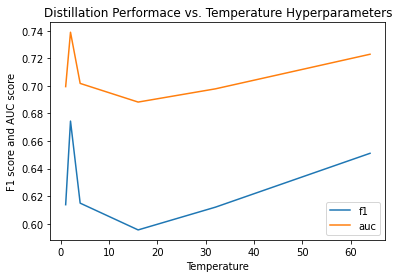

In [ ]:
T = [1, 2, 4, 16, 32, 64]
student_f1_list = []
student_auc_list = []
for temp in T:
  student_model = student_initial()
  distiller = KD(student=student_model, teacher=teacher_model)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = temp,
  )
  distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

  stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
  stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))

  student_f1_list.append(stu_f1_score)
  student_auc_list.append(stu_auc)

  print(temp,'Temperature done')
print('student_f1_list is',student_f1_list)
print('student_auc_list is',student_auc_list)
plt.plot(T, student_f1_list, label='f1')
plt.plot(T, student_auc_list, label='auc')
plt.xlabel("Temperature")
plt.ylabel("F1 score and AUC score")
plt.title("Distillation Performace vs. Temperature Hyperparameters")
plt.legend()
plt.show()

Epoch 1/25
68/68 [==============================] - 12s 121ms/step - sparse_categorical_accuracy: 0.7195 - student_loss: 0.5659 - distillation_loss: 2.7709
Epoch 2/25
68/68 [==============================] - 8s 122ms/step - sparse_categorical_accuracy: 0.7692 - student_loss: 0.4784 - distillation_loss: 2.7699
Epoch 3/25
68/68 [==============================] - 8s 123ms/step - sparse_categorical_accuracy: 0.7959 - student_loss: 0.4354 - distillation_loss: 2.7695
Epoch 4/25
68/68 [==============================] - 8s 123ms/step - sparse_categorical_accuracy: 0.8018 - student_loss: 0.4204 - distillation_loss: 2.7693
Epoch 5/25
68/68 [==============================] - 8s 121ms/step - sparse_categorical_accuracy: 0.8074 - student_loss: 0.4126 - distillation_loss: 2.7692
Epoch 6/25
68/68 [==============================] - 8s 121ms/step - sparse_categorical_accuracy: 0.8221 - student_loss: 0.3911 - distillation_loss: 2.7690
Epoch 7/25
68/68 [==============================] - 8s 121ms/step - s

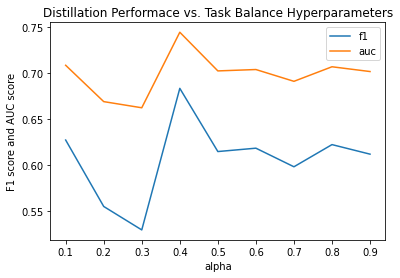

In [ ]:
alpha_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
student_f1_list = []
student_auc_list = []
for alpha in alpha_list:
  student_model = student_initial()
  distiller = KD(student=student_model, teacher=teacher_model)
  distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=alpha,
      temperature = 2,
  )
  distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

  stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
  stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))

  student_f1_list.append(stu_f1_score)
  student_auc_list.append(stu_auc)

  print(alpha,'alpha done')
print('student_f1_list is',student_f1_list)
print('student_auc_list is',student_auc_list)
plt.plot(alpha_list, student_f1_list, label='f1')
plt.plot(alpha_list, student_auc_list, label='auc')
plt.xlabel("alpha")
plt.ylabel("F1 score and AUC score")
plt.title("Distillation Performace vs. Task Balance Hyperparameters")
plt.legend()
plt.show()

## Train Student from scratch

In [ ]:
student_model = student_initial()

In [ ]:
student_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Train student from scratch
student_model.fit(mhist_train_img, mhist_train_label_le, steps_per_epoch=68, epochs=25)

Epoch 1/25
68/68 [==============================] - 13s 47ms/step - loss: 0.5912 - sparse_categorical_accuracy: 0.7016
Epoch 2/25
68/68 [==============================] - 3s 41ms/step - loss: 0.4714 - sparse_categorical_accuracy: 0.7720
Epoch 3/25
68/68 [==============================] - 3s 41ms/step - loss: 0.4497 - sparse_categorical_accuracy: 0.7908
Epoch 4/25
68/68 [==============================] - 3s 42ms/step - loss: 0.4247 - sparse_categorical_accuracy: 0.8041
Epoch 5/25
68/68 [==============================] - 3s 42ms/step - loss: 0.4101 - sparse_categorical_accuracy: 0.8060
Epoch 6/25
68/68 [==============================] - 3s 42ms/step - loss: 0.3960 - sparse_categorical_accuracy: 0.8198
Epoch 7/25
68/68 [==============================] - 3s 41ms/step - loss: 0.3948 - sparse_categorical_accuracy: 0.8225
Epoch 8/25
68/68 [==============================] - 3s 42ms/step - loss: 0.3758 - sparse_categorical_accuracy: 0.8326
Epoch 9/25
68/68 [==============================] - 3s 

In [ ]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)

31/31 [==============================] - 2s 33ms/step
Student f1 score is 0.550098231827112


In [ ]:
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 1s 34ms/step
Student auc is 0.5825679812713849


## Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

In [ ]:
# your code start from here for step 8
teacherflops = get_flops(teacher_model)
studentflops = get_flops(student_model)
print('flops for teacher ResNet model is',teacherflops)
print('flops for student MobileNet model is',studentflops)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


flops for teacher ResNet model is 6988381836
flops for student MobileNet model is 612731340


In [ ]:
teacher_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
student_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_31[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

## Adding TA

In [ ]:
def ta_initial():
  Res = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False, input_shape=(224, 224, 3))
  Res.trainable = False
  '''for layer in Res.layers[:186]:
    layer.trainable = False
  for layer in Res.layers[-4:]:
    layer.trainable = True'''

  average_tea = tf.keras.layers.GlobalAveragePooling2D()(Res.output)
  dense_tea = tf.keras.layers.Dense(2, activation = 'softmax')(average_tea)
  ta_model = Model(inputs=Res.input, outputs=dense_tea)
  return ta_model

In [ ]:
def ta_initial_mob():
  Mob = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape=(224, 224, 3))
  Mob.trainable = False
  for layer in Mob.layers[:149]:
    layer.trainable = False
  for layer in Mob.layers[-3:]:
    layer.trainable = True

  average_tea = tf.keras.layers.GlobalAveragePooling2D()(Mob.output)
  dense_tea = tf.keras.layers.Dense(2, activation = 'softmax')(average_tea)
  ta_model = Model(inputs=Mob.input, outputs=dense_tea)
  return ta_model

In [ ]:
ta_model = ta_initial()

In [ ]:
ta_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
distiller = KD(student=ta_model, teacher=teacher_model)
distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = 1,
  )

In [ ]:
distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 15s 170ms/step - sparse_categorical_accuracy: 0.7274 - student_loss: 0.5361 - distillation_loss: 0.6862
Epoch 2/25
68/68 [==============================] - 12s 173ms/step - sparse_categorical_accuracy: 0.7811 - student_loss: 0.4456 - distillation_loss: 0.6827
Epoch 3/25
68/68 [==============================] - 12s 178ms/step - sparse_categorical_accuracy: 0.8133 - student_loss: 0.3972 - distillation_loss: 0.6807
Epoch 4/25
68/68 [==============================] - 12s 176ms/step - sparse_categorical_accuracy: 0.8285 - student_loss: 0.3798 - distillation_loss: 0.6800
Epoch 5/25
68/68 [==============================] - 12s 174ms/step - sparse_categorical_accuracy: 0.8294 - student_loss: 0.3650 - distillation_loss: 0.6795
Epoch 6/25
68/68 [==============================] - 12s 172ms/step - sparse_categorical_accuracy: 0.8520 - student_loss: 0.3424 - distillation_loss: 0.6785
Epoch 7/25
68/68 [==============================] - 12s 171ms/st

In [ ]:
student_model = student_initial()

In [ ]:
distiller = KD(student=student_model, teacher=ta_model)
distiller.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(),
      alpha=0.5,
      temperature = 1,
  )

In [ ]:
distiller.fit(mhist_train_img, mhist_train_label_le, epochs=25)

Epoch 1/25
68/68 [==============================] - 12s 119ms/step - sparse_categorical_accuracy: 0.7375 - student_loss: 0.5369 - distillation_loss: 0.6872
Epoch 2/25
68/68 [==============================] - 8s 119ms/step - sparse_categorical_accuracy: 0.7862 - student_loss: 0.4523 - distillation_loss: 0.6847
Epoch 3/25
68/68 [==============================] - 8s 120ms/step - sparse_categorical_accuracy: 0.7917 - student_loss: 0.4367 - distillation_loss: 0.6845
Epoch 4/25
68/68 [==============================] - 8s 122ms/step - sparse_categorical_accuracy: 0.8124 - student_loss: 0.4044 - distillation_loss: 0.6837
Epoch 5/25
68/68 [==============================] - 8s 121ms/step - sparse_categorical_accuracy: 0.8175 - student_loss: 0.3896 - distillation_loss: 0.6832
Epoch 6/25
68/68 [==============================] - 8s 122ms/step - sparse_categorical_accuracy: 0.8257 - student_loss: 0.3697 - distillation_loss: 0.6829
Epoch 7/25
68/68 [==============================] - 8s 122ms/step - s

In [ ]:
stu_f1_score = f1_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student f1 score is',stu_f1_score)

31/31 [==============================] - 2s 33ms/step
Student f1 score is 0.5977011494252873


In [ ]:
stu_auc = roc_auc_score(mhist_test_label_le, np.argmax(student_model.predict(mhist_test_img), axis=1))
print('Student auc is',stu_auc)

31/31 [==============================] - 1s 33ms/step
Student auc is 0.6851611741401045
